In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [27]:
def InitialCondition_Heavyside(r, r0, Sigma0):
    Sigma=Sigma0*np.heaviside(r0-r,0.5)
    return Sigma
    
def InitialCondition_Delta(r,r0,Sigma0):
    dr=r[1]-r[0]
    Sigma=np.zeros(r.size)
    delta= np.where(np.fabs(r-r0)<=dr)[0]
    
    Sigma[delta]=Sigma0* (1.0 - np.fabs(r-r0)[delta]/dr) 
    return Sigma
    

In [28]:
def BoundaryCondition_BothSides(r, Sigma, boundary):
    Sigma[0]=boundary
    Sigma[-1]=boundary

def BoundaryCondition_Inner(r,Sigma,boundary):
    Sigma[0]=boundary

def BoundaryCondition_Outer(r,Sigma,boundary):
    Sigma[-1]=boundary

In [29]:
def CFL_Condition_Diff(dr,Diffusion):
    if Diffusion>0:
        Courant_Diff= 0.3*dr*dr/Diffusion
        return Courant_Diff
    else:
        return np.infty
    
def CFL_Condition_Vel(dr,u):
    v_max=np.amax(u)
    if v_max>0:
        Courant_Vel= np.divide(0.3*dr,v_max)
        return np.amin(Courant_Vel)
    else:
        return np.infty

In [30]:
def DonnorCell_Advection(r,q,u):
    nr=r.size
    dr=r[1]-r[0]
    
    u_05= 0.5*(u[0:nr-1]+u[1:nr]) #Velocity at the Interfaces
    flux_05= np.zeros(nr-1)  #Flux at the interfaces
    
    positive=np.where(u_05>0)[0]  #Interfaces where the flux comes from the left
    negative=np.where(u_05<0)[0]  #Interfaces where the flux comes from the right
        
    flux_05[positive]= np.multiply(q[positive], u_05[positive])
    flux_05[negative]= np.multiply(q[negative+1], u_05[negative])
    
    q_flux=np.zeros(nr)
    q_flux[1:nr-1]= (flux_05[0:nr-2]-flux_05[1:nr-1])/dr
    
    return q_flux
    
    

In [54]:
nr=50
r_min=0.0
r_max=1.0

t_start=0.0
t_end=10.0*2*np.pi
dt=0.01

t_output=(t_end-t_start)/5.0


Sigma0=1.0
Diffusion=0.001
Velocity= 0.05
r0=0.5


dr=(r_max-r_min)/nr
r=np.linspace(r_min+0.5*dr,r_max-0.5*dr,num=nr,endpoint=True)

u=Velocity*np.ones(nr)
Sigma=InitialCondition_Heavyside(r,r0,Sigma0)

#Sigma=Sigma0*np.ones(nr)
#u=Velocity*np.multiply(np.ones(nr),2*np.heaviside(r0-r,0.5)-1)


In [55]:
t=t_start
t_save=t_output

Output_Dens=[]
Output_Dens.append(np.copy(Sigma))

while t<t_end:
    
    #Find the timestep using Courant Condition
    dt_0=np.amin([dt,t_save,CFL_Condition_Diff(dr,Diffusion),CFL_Condition_Vel(dr,u)])
    
    #Evolve the Density
    dsigma_dt=np.zeros(nr)
    dsigma_dt[1:nr-1]+=(Sigma[2:nr]+Sigma[0:nr-2]-2.0*Sigma[1:nr-1])*Diffusion/(dr*dr)    
    dsigma_dt+=DonnorCell_Advection(r,Sigma,u)
    Sigma+=dsigma_dt*dt_0
    
    #Apply Boundary Conditions
    #Notice that the cells 0 and nr-1 are treated as ghost cells and never touched except by the boundary conditions
    #BoundaryCondition_BothSides(r,Sigma,0.0)
    BoundaryCondition_Inner(r,Sigma,Sigma0)
    BoundaryCondition_Outer(r,Sigma,0.0)
    
    
    
    
    #Check if it is time to save
    t_save-=dt_0
    if t_save<=0.0:
        t_save=t_output
        Output_Dens.append(np.copy(Sigma))
    #Update the Time
    t+=dt_0

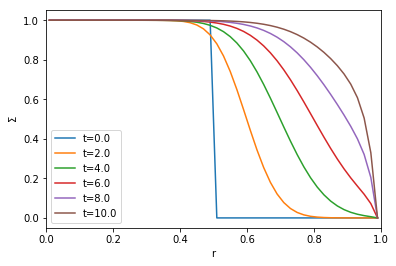

In [56]:
plt.xlabel("r")
plt.ylabel("$\mathdefault{\Sigma}$")
plt.xlim([r_min,r_max])
#plt.ylim([0.0,1.1])

for s in range(len(Output_Dens)):
    plt.plot(r,Output_Dens[s],label="t="+str(t_output*s))
    plt.legend()